<a href="https://colab.research.google.com/github/G-Shillcock/Division_of_Labour/blob/main/DoL_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

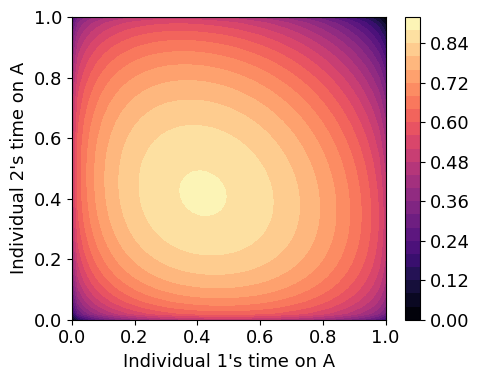

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from tqdm.notebook import tqdm
from sympy import var, plot_implicit, Eq

def performance(effort,task_difficulty):

    return effort**task_difficulty


def fitness(x,a,b,λ):

    t1, t2 = x

    A1 = performance(t1,a)
    A2 = performance(t2,a)
    B1 = performance(1-t1,b)
    B2 = performance(1-t2,b)

    return (1-λ)*(A1*B1+A2*B2)+λ*(A1*B2+A2*B1)

# CONTOUR FOR A SINGLE POINT IN (a,b,λ) SPACE

fig, ax = plt.subplots(figsize=(5,4))
plt.rcParams.update({'font.size': 13})

plt.xlabel('Individual 1\'s time on A')
plt.ylabel('Individual 2\'s time on A')

effort = np.linspace(0,1,50)
T1,T2 = np.meshgrid(effort, effort)
fit = fitness([T1,T2], a=.5, b=.7, λ=.2)

con = plt.contourf(T1, T2, fit, levels=25, cmap='magma')
plt.colorbar(con)

plt.tight_layout()
plt.savefig("contour.svg")

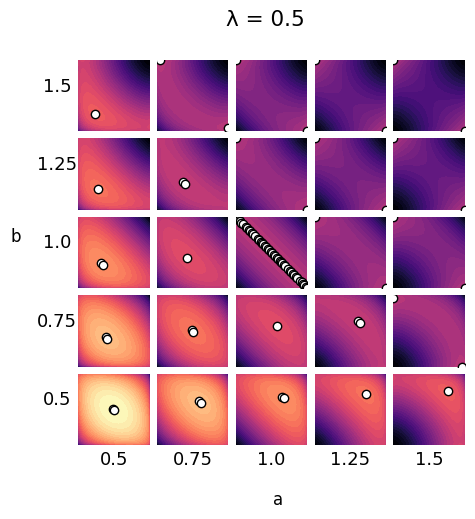

In [15]:
def plot_contours(λ):

    g = 5
    fig, ax = plt.subplots(g,g,figsize=[5,5], sharex=True, sharey=True)
    fig.subplots_adjust(wspace=.1, hspace=.1)
    fig.text(0.525, 0, 'a', ha='center', va='center', fontsize=12)
    fig.text(0, 0.525, 'b', ha='center', va='center', fontsize=12)
    fig.suptitle(f'λ = {λ}')


    for (i, b), (j, a) in it.product(enumerate(np.linspace(0.5,1.5,g)), repeat=2):

        fit = fitness([T1,T2],a,b,λ)

        # plot contour
        con = ax[g-1-i,j].contourf(T1, T2, fit, levels=np.linspace(0,1,40), cmap='magma')
        # plt.colorbar(con, ax=ax[g-1-i,j], format='%.2f')

        # plot fitness maximums
        id_maxs = np.argwhere(fit == np.amax(fit))
        for x,y in id_maxs:
            ax[g-1-i,j].plot(effort[x],effort[y], 'o', markerfacecolor='white', markeredgecolor='black')

        # make pretty
        ax[i,j].set_xticks([])
        for spine in ax[i,j].spines.values():
            spine.set_visible(False)
        ax[i,j].set_yticks([])
        if i==g-1: ax[i,j].set_xlabel(f'{a}')
        if j==0: ax[g-1-i,j].set_ylabel(f'{b}', rotation=0, labelpad=15)
        plt.savefig(f'contours_{λ}.svg')

    plt.show()

# CONTOURS FOR VARIED TASK DIFFICULTY a AND b

effort = np.linspace(0,1,50)
T1,T2 = np.meshgrid(effort, effort)

task_difficulty = np.linspace(0.01,3,100)
a,b = np.meshgrid(task_difficulty, task_difficulty)

for λ in [0.5]:
    plot_contours(λ)

In [27]:
def calc_specialist_region(λ):

    is_specialist = np.full((len(task_difficulty),len(task_difficulty)), np.nan)
    max_fitness = np.full((len(task_difficulty),len(task_difficulty)), np.nan)


    for (i, b), (j, a) in tqdm(it.product(enumerate(task_difficulty), repeat=2), total=len(task_difficulty)**2):

        fit = fitness([T1,T2],a,b,λ)

        max_fitness[i,j] = np.amax(fit)

        ids = np.argwhere(fit == np.amax(fit))
        if np.sum([abs(id[0]-id[1]) for id in ids]) > 2:
            is_specialist[i,j] = 1

    with open('data_outfile.npy', 'wb') as f:
        np.savez(f, is_specialist=is_specialist)

    return is_specialist, max_fitness


def plot_specialist_region(is_specialist, max_fitness, λ):

    # with open('data_outfile.npy', 'rb') as f:
    #     is_specialist = np.load(f)['is_specialist']

    lb, ub = task_difficulty[0], task_difficulty[-1]

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.suptitle(f'λ = {λ}')

    ax[0].set_xlabel('a')
    ax[0].set_ylabel('b')

    ax[0].set_xlim([0,ub])
    ax[0].set_ylim([0,ub])

    ax[0].imshow(is_specialist, origin='lower', extent=[lb, ub, lb, ub], cmap='magma')

    a = np.linspace(1/(4*λ)+.01,4)
    ax[0].plot(a,a/(4*λ*a-1))

    a = np.linspace(0.01,4)
    b = np.linspace(0.01,4)

    aa,bb = np.meshgrid(a,b)

    F = ((aa+bb)/aa)**aa
    ax[0].contour(aa,bb,F-2,[0])

    ax[1].set_xlim([0,ub])
    ax[1].set_ylim([0,ub])

    im = ax[1].imshow(max_fitness, origin='lower', extent=[lb, ub, lb, ub])
    ax[1].plot(a,a/(4*λ*a-1),'w')

    cbar = fig.colorbar(im)
    im.set_clim(0, 2)
    plt.show()

    fig.savefig(f'is_specialist{λ}.svg')

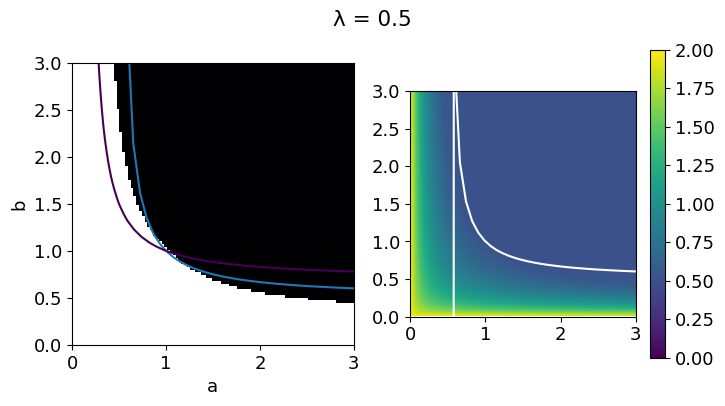

In [28]:
effort = np.linspace(0,1,50)
T1,T2 = np.meshgrid(effort, effort)

task_difficulty = np.linspace(0.01,3,100)
a,b = np.meshgrid(task_difficulty, task_difficulty)

for λ in [.5]:

    # plot_contours(λ)
    # is_specialist, max_fitness = calc_specialist_region(λ)
    plot_specialist_region(is_specialist, max_fitness, λ)

    # fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    # ax.set_title(f'λ = {λ}', y=1)
    # ax.set_xlabel('Task A difficulty')
    # ax.set_ylabel('Task B difficulty')
    # ax.set_zlabel('Fitness Max')
    # surf = ax.plot_surface(a,b, max_fitness, shade=False, cmap="inferno", linewidth=1)
    # plt.draw()
    # surf.set_edgecolors(surf.to_rgba(surf._A))
    # surf.set_facecolors("white")
    # ax.set_zlim(0, 2)
    # ax.view_init(20, 10);
    # plt.show()